In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import *
import matplotlib.pyplot as plt

In [2]:
TRANSITION = 0.9
B_DURATION = 4
DIS_COST_SCALE = 5

First, read in problem parameters. These can come from any source, but they should be reshaped into a `pandas.DataFrame` object with the format shown here

In [3]:
input = pd.read_excel('Mini_California_Model_Inputs.xlsx', sheet_name=None)

In [4]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Installed generation capacities
installed = np.array(input['Gen']['Installed MW'])

# The initial conditions of the demand curves
load = input['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
load.index = load.index.map(lambda t: t.replace(year=2021))
demand = load.loc[:,load.columns.str.contains('Load')]/base
demand.columns = demand.columns.str.replace('Load','').astype(int)
price = load.loc[:,load.columns.str.contains('Price')]
price.columns = price.columns.str.replace('Price','').astype(int)
price = price*base

# Generation profiles for intermittant sources
int_gen = input['NormGenProfiles'].set_index('2021 Datetime')
int_gen = int_gen.loc[load.index, input['Gen']['Type']]
int_gen = int_gen*installed/base
int_gen.columns = np.array(input['Gen']['Number of Bus'])

# Set elasticity constant, for now
epsilon = demand.copy()
epsilon[:] = -.7

voll = price.copy()
voll[:] = base*1000

profile = pd.concat(
    {
        'nom_load': demand,
        'nom_price': price,
        'elasticity': epsilon,
        'voll': voll,
        'int_gen': int_gen
    },
    axis='columns'
)

profile.int_gen = TRANSITION*profile.int_gen

# Process Ybus matrix
Y = input['YBus']
Y = Y.drop(columns=['Number'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = input['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Dispatchable generator costs, in the form [linear; quadratic]
cost_coeffs = DIS_COST_SCALE*np.array(
    [
        [10,8,12],
        [.016,0.18,0.18]
    ]
)
cost_coeffs = [[base],[base^2]]*cost_coeffs

# Generator limits
dis_max = (1-TRANSITION)*installed/base

# Total storage capacity
total_storage = TRANSITION*installed.sum()/base

# Single-day run
profile = profile.loc[profile.index.day == profile.index.day[0]]

Instantiate model

In [5]:
model = Network(
    B=B,
    line_lims=P_line,
    profile=profile,
    dis_max=dis_max,
    total_storage=total_storage,
    storage_cycle_timesteps=B_DURATION,
    cost_coeffs=cost_coeffs,
    cycle_storage=True
)

def reset_to_nominal():
    '''resets the model to have nominal values - make sure anything being varied has its nominal value specified here.'''
    model.profile.elasticity = -0.7
    model.profile.int_gen = TRANSITION*profile.int_gen
    model.dis_max = (1-TRANSITION)*installed/base
    model.line_lims = P_line
    model.total_storage = total_storage 
    model.cost_coeffs = cost_coeffs

Solve model. This will add output data to the `model.profile` dataframe as well as the following model attributes:
- `model.storage_capacity`: the storage capacity allocated to each bus
- `model.initial_charge`: the initial state-of-charge of each storage unit

In [6]:
model.solve()

Plot all the prices and their nominal values (dotted). Bus 1 has no nominal price because it does not have a load.

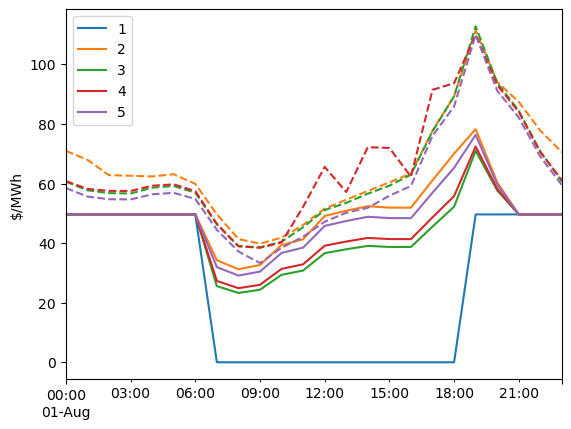

In [7]:
fig, ax = plt.subplots()
(model.profile.price/base).plot(ax=ax)
# Save colors for consistency
colors = np.array([line.get_color() for line in ax.lines])
ax.set_prop_cycle(None)
(model.profile.nom_price/base).plot(ax=ax,style='--',color=colors[model.profile.nom_price.columns-1],legend=False)
ax.set_ylabel('$/MWh')
fig.show()

Similar idea with the loads - nominal dotted, actual solid

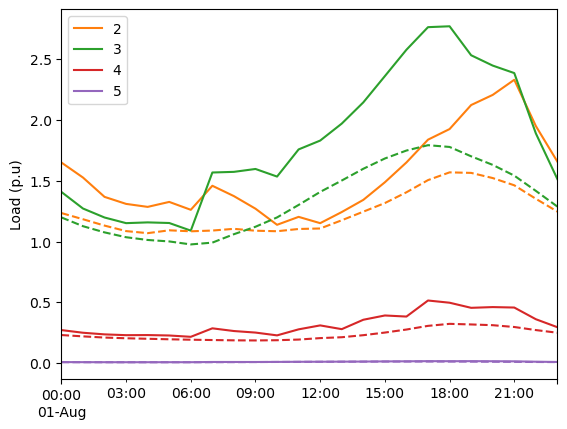

In [8]:
fig, ax = plt.subplots()
model.profile.load.plot(ax=ax,color=colors[model.profile.load.columns-1])
model.profile.nom_load.plot(ax=ax,style='--',color=colors[model.profile.load.columns-1],legend=False)
ax.set_ylabel('Load (p.u)')
fig.show()

Compute the dispatchable and intermittent (dotted) generation

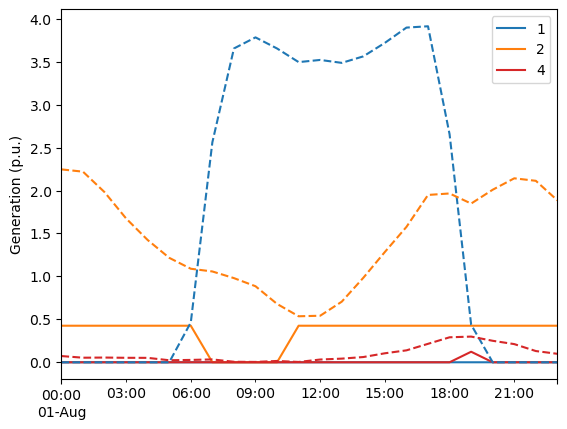

In [9]:
dispatchable = model.profile.generation - model.profile.int_gen
dispatchable[dispatchable < 0] = 0
intermittent = model.profile.generation - dispatchable

fig, ax = plt.subplots()
dispatchable.plot(ax=ax,color=colors[dispatchable.columns-1])
intermittent.plot(ax=ax,style='--',color=colors[intermittent.columns-1],legend=False)
ax.set_ylabel('Generation (p.u.)')
fig.show()

Compute producer (solid) and consumer (dashed) surplus according to:
- Consumer surplus = revenue - cost
- Producer surplus = utility - expenses

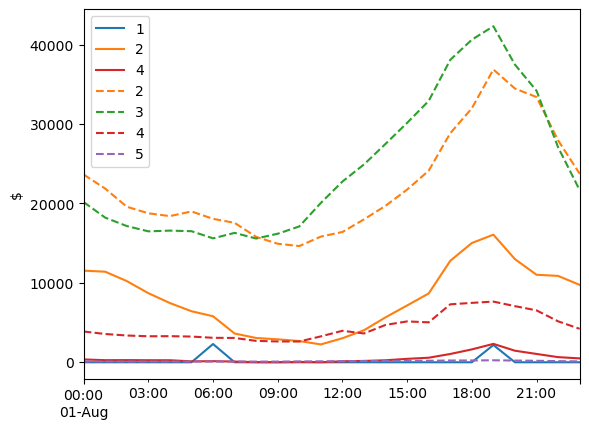

In [10]:
producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]

fig, ax = plt.subplots()
producer_surplus.plot(ax=ax,color=colors[producer_surplus.columns-1])
consumer_surplus.plot(ax=ax,style='--',color=colors[consumer_surplus.columns-1])
ax.set_ylabel('$')
fig.show()

Compute line loading, as a percentage. A negative value indicates power is flowing in the reverse direction with respect to the legend.

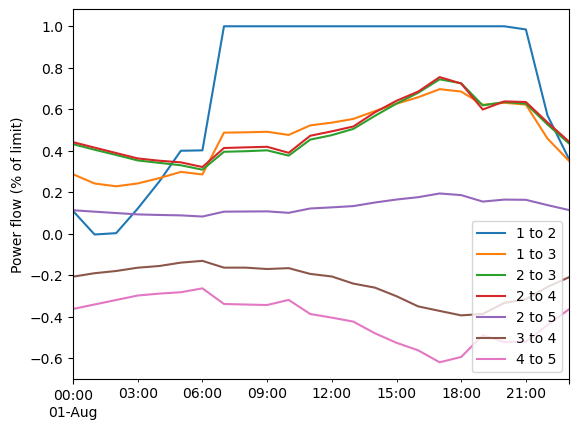

In [11]:
origin, destination = np.triu_indices(model.B.shape[0],1)
line_flows = model.profile.angle.apply(
    lambda row: pd.Series((model.B*outer_difference(row.to_numpy()))[(origin,destination)]),
    axis='columns'
)
line_flows.columns = [f'{origin[k]+1} to {destination[k]+1}' for k in range(len(line_flows.columns))]
lims = model.line_lims[(origin,destination)]
edge_idx = np.nonzero(lims)[0]
line_flows = line_flows.iloc[:,edge_idx]/lims[edge_idx]

fig, ax = plt.subplots()
line_flows.plot(ax=ax)
ax.set_ylabel('Power flow (% of limit)')
fig.show()

State-of-charge computation

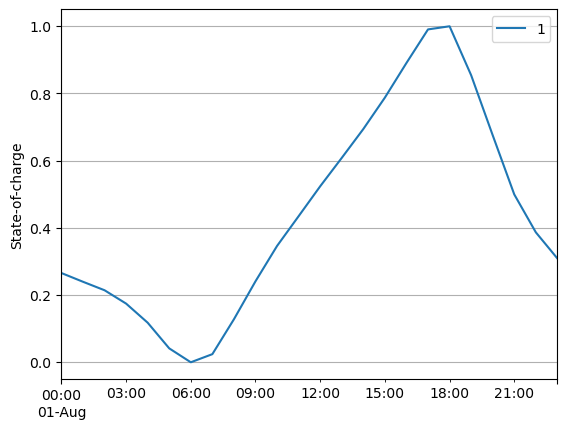

In [12]:
storage_mask = model.storage_capacity >= 1e-3
soc = model.initial_charge + model.profile.storage_load.cumsum()
soc = soc.loc[:,storage_mask]/model.storage_capacity[storage_mask]

fig, ax = plt.subplots()
soc.plot(ax=ax)
ax.set_ylabel('State-of-charge')
ax.grid()
fig.show()

Produce transition plots for nominal parameter values.

In [13]:
reset_to_nominal()
nom_results = {}
for t in np.linspace(0.0, 1.0, 11):
    print('Computing for transition = '+str(t)+'...')
    model.profile.int_gen = t*int_gen
    model.dis_max = (1-t)*installed/base
    model.total_storage = t*installed.sum()/base
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]
    dispatchable = model.profile.generation - model.profile.int_gen
    dispatchable[dispatchable < 0] = 0
    intermittent = model.profile.generation - dispatchable
    dispatchable_surplus = dispatchable*model.profile.price[dispatchable.columns]-model.profile.cost
    intermittent_surplus = intermittent*model.profile.price[intermittent.columns]
    nom_results[t] = pd.Series(
        {
            'load': base*model.profile.load.sum().sum(),
            'load_minus_nom': base*(model.profile.load - model.profile.nom_load).sum().sum(),
            'dispatchable': base*dispatchable.sum().sum(),
            'VRE': base*intermittent.sum().sum(),
            'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-t)/installed.sum(),
            'VRE_surplus': intermittent_surplus.sum().sum()/t/installed.sum(),
            'producer_surplus': producer_surplus.sum().sum()/installed.sum(),
            'average_price': model.profile.price.mean(axis=None)/base,
            'max_price': model.profile.price.max(axis=None)/base,
            'min_price': model.profile.price.min(axis=None)/base,
            'std_price': np.std(model.profile.price.to_numpy().flatten())/base
        }
    )
nom_results = pd.DataFrame(nom_results).T
nom_results.index.name = 'transition'
nom_results

Computing for transition = 0.0...


/tmp/ipykernel_1142/2458058889.py:23: RuntimeWarning: invalid value encountered in scalar divide
  'VRE_surplus': intermittent_surplus.sum().sum()/t/installed.sum(),


Computing for transition = 0.1...
Computing for transition = 0.2...
Computing for transition = 0.30000000000000004...
Computing for transition = 0.4...
Computing for transition = 0.5...
Computing for transition = 0.6000000000000001...
Computing for transition = 0.7000000000000001...
Computing for transition = 0.8...
Computing for transition = 0.9...
Computing for transition = 1.0...


/tmp/ipykernel_1142/2458058889.py:22: RuntimeWarning: invalid value encountered in scalar divide
  'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-t)/installed.sum(),


,load,load_minus_nom,dispatchable,VRE,dispatchable_surplus,VRE_surplus,producer_surplus,average_price,max_price,min_price,std_price
transition,,,,,,,,,,,
0.0,8829.702183,2044.034283,8829.702111,0.000000,20.957315,NaN,20.957315,46.765704,52.165537,4.402162e+01,2.216053
0.1,8906.715186,2121.047286,7756.182523,1150.532672,20.191557,347.155979,52.887999,46.224863,50.411886,4.337379e+01,2.424159
0.2,8982.082897,2196.414997,6681.017553,2301.065344,19.362016,341.750608,83.839734,45.692237,50.373135,4.272609e+01,2.706983
0.3,9063.771209,2278.103309,5612.173192,3451.598015,18.668512,335.846801,113.821998,45.151803,50.334376,4.207958e+01,2.965002
0.4,9130.391626,2344.723726,4528.260918,4602.130687,19.448783,323.725344,141.159408,44.567218,53.724389,4.010001e+01,3.753411
0.5,9500.138832,2714.470932,3901.064762,5599.073214,25.429389,149.002590,87.215990,39.780929,62.824898,5.298289e-06,13.702157
0.6,9415.630182,2629.962282,3176.594330,6239.035528,33.596255,150.623177,103.812409,40.380779,63.820572,1.802671e-07,14.097888
0.7,9338.217443,2552.549543,2471.549004,6866.666937,41.482598,145.050033,113.979802,40.427703,66.435492,5.812133e-07,15.143612
0.8,9153.894345,2368.226445,1696.803048,7457.090792,53.184908,146.689810,127.988830,41.127532,71.999982,4.170435e-08,15.760666


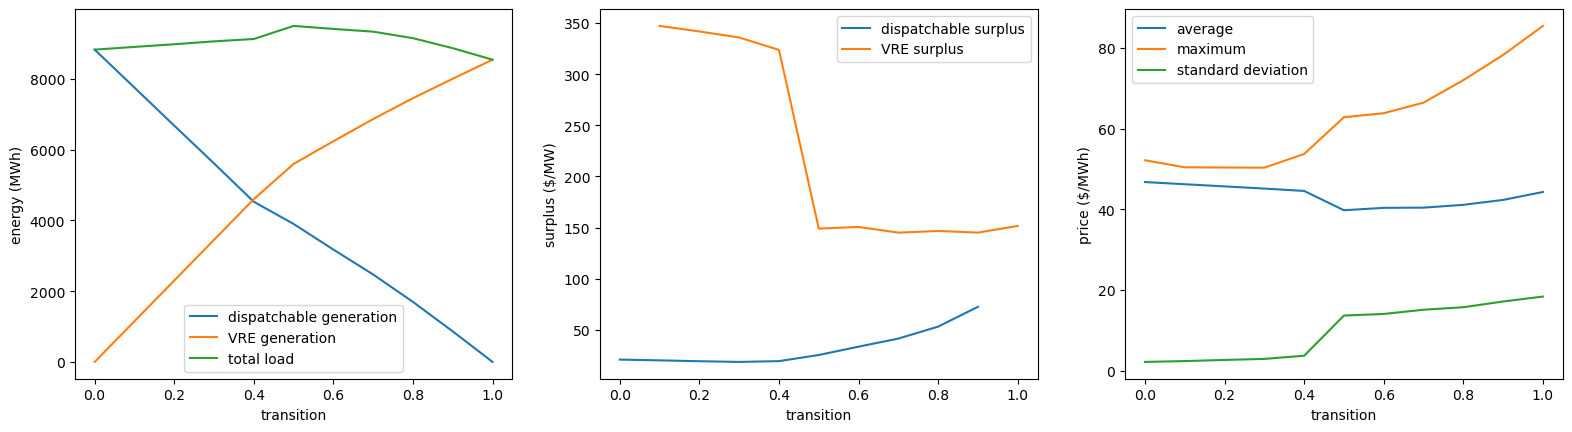

In [14]:
fig, ax = plt.subplots(1,3)
nom_results[['dispatchable','VRE','load']].plot(ax=ax[0])
nom_results[['dispatchable_surplus','VRE_surplus']].plot(ax=ax[1])
nom_results[['average_price','max_price','std_price']].plot(ax=ax[2])
[a.set_xlabel('transition') for a in ax]
ax[0].set_ylabel('energy (MWh)')
ax[0].legend(['dispatchable generation', 'VRE generation', 'total load'])
ax[1].set_ylabel('surplus ($/MW)')
ax[1].legend(['dispatchable surplus', 'VRE surplus'])
ax[2].set_ylabel('price ($/MWh)')
ax[2].legend(['average', 'maximum', 'standard deviation'])
fig.set_size_inches(fig.get_size_inches()*[3,1])

In [15]:
# Sensitivity plot functions 
def run_analysis(model, current_val, nominal_val):
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    dispatchable = model.profile.generation - model.profile.int_gen
    dispatchable[dispatchable < 0] = 0
    intermittent = model.profile.generation - dispatchable
    dispatchable_surplus = dispatchable*model.profile.price[dispatchable.columns]-model.profile.cost
    intermittent_surplus = intermittent*model.profile.price[intermittent.columns]
    output = pd.Series(
        {
            'producer_surplus': producer_surplus.sum().sum()/installed.sum(),
            'total_consumption': base*model.profile.load.sum().sum(),
            'average_price': model.profile.price.mean(axis=None)/base,
            'max_price': model.profile.price.max(axis=None)/base,
            'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-TRANSITION)/installed.sum(),
            'VRE_surplus': intermittent_surplus.sum().sum()/TRANSITION/installed.sum(),
            'xlabl': 100*(current_val/nominal_val - 1)
        }
    )
    return output

def sensitivity_plot(results):
    results = pd.DataFrame(results).T
    results.plot(y='producer_surplus', x='xlabl', ax=ax[0,0])
    results.plot(y="total_consumption", x="xlabl", ax=ax[0,1])
    results.plot(y="average_price", x="xlabl", ax=ax[1,0])
    results.plot(y="max_price", x="xlabl", ax=ax[1,1])
    results.plot(y='dispatchable_surplus', x='xlabl', ax=ax[2,0])
    results.plot(y='VRE_surplus', x='xlabl', ax=ax[2,1])

Produce sensitivity plots showing sensitivity of producer surplus, consumer surplus, and average price to parameter values.

/opt/conda/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


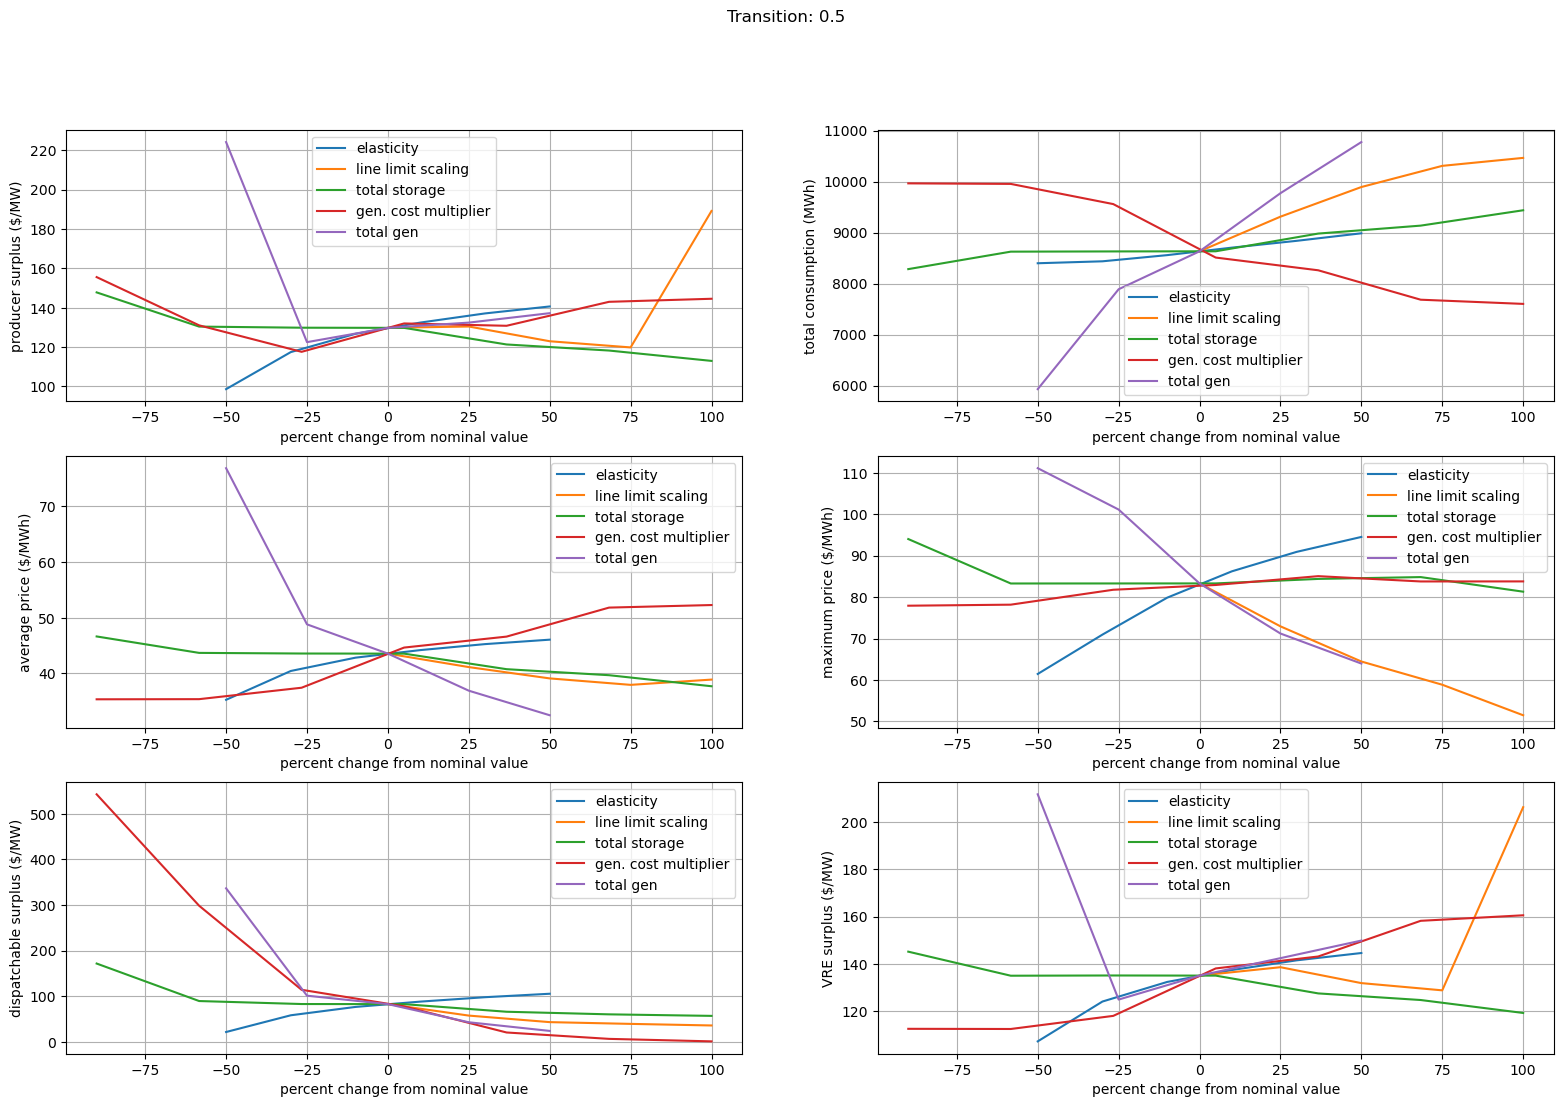

In [16]:
# Produce sensitivity plot - x axis is % change in input from its reference, y is measure of variable of interest.

fig, ax = plt.subplots(3,2)

# Set the transition 
transition = 0.5

# Vary elasticity 
results = {}
for i in np.linspace(0.5, 1.5, 6):
    reset_to_nominal()
    model.profile.elasticity = model.profile.elasticity*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Line limit scaling 
results = {}
for i in np.linspace(1.0, 2.0, 5):
    reset_to_nominal()
    model.line_lims = P_line*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Storage scaling
results = {}
for i in np.linspace(0.1, 2.0, 7):
    reset_to_nominal()
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# generator costs  
results = {}
for i in np.linspace(0.1, 2.0, 7):
    reset_to_nominal()
    model.cost_coeffs = cost_coeffs*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Total generation 
results = {}
for i in np.linspace(0.5, 1.5, 5):
    reset_to_nominal()
    model.profile.int_gen = model.profile.int_gen*i
    model.dis_max = model.dis_max*i
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

[a.set_xlabel('percent change from nominal value') for row in ax for a in row]
ax[0,0].set_ylabel('producer surplus ($/MW)')
ax[0,1].set_ylabel('total consumption (MWh)')
ax[1,0].set_ylabel('average price ($/MWh)')
ax[1,1].set_ylabel('maximum price ($/MWh)')
ax[2,0].set_ylabel('dispatchable surplus ($/MW)')
ax[2,1].set_ylabel('VRE surplus ($/MW)')
fig.suptitle("Transition: "+str(transition))
[a.grid() for row in ax for a in row]
fig.set_size_inches(fig.get_size_inches()*[3,2.5])
[a.legend(['elasticity', 'line limit scaling', 'total storage', 'gen. cost multiplier', 'total gen']) for row in ax for a in row]

fig.show()

/opt/conda/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


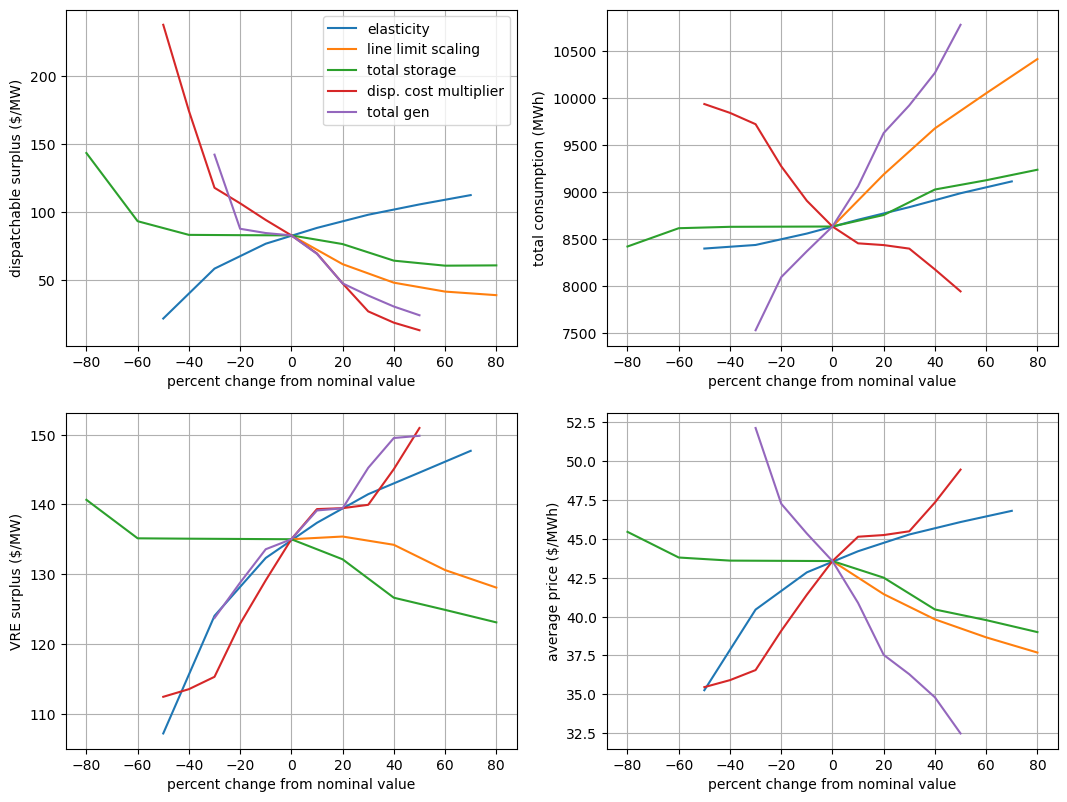

In [17]:
# square plot for overleaf 

fig, ax = plt.subplots(2,2)

def sensitivity_plot_small(results):
    results = pd.DataFrame(results).T

    results.plot(y='dispatchable_surplus', x='xlabl', ax=ax[0,0])
    results.plot(y='VRE_surplus', x='xlabl', ax=ax[1,0], legend=None)
    results.plot(y="total_consumption", x="xlabl", ax=ax[0,1], legend=None)
    results.plot(y="average_price", x="xlabl", ax=ax[1,1], legend=None)

# Set the transition 
transition = 0.9

# Vary elasticity 
results = {}
for i in np.linspace(0.5, 1.7, 7):
    reset_to_nominal()
    model.profile.elasticity = model.profile.elasticity*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# Line limit scaling 
results = {}
for i in np.linspace(1.0, 1.8, 5):
    reset_to_nominal()
    model.line_lims = P_line*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# Storage scaling
results = {}
for i in np.linspace(0.2, 1.8, 9):
    reset_to_nominal()
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# generator costs  
results = {}
for i in np.linspace(0.5, 1.5, 11):
    reset_to_nominal()
    model.cost_coeffs = cost_coeffs*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# Total generation 
results = {}
for i in np.linspace(0.7, 1.5, 9):
    reset_to_nominal()
    model.profile.int_gen = model.profile.int_gen*i
    model.dis_max = model.dis_max*i
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

[a.set_xlabel('percent change from nominal value') for row in ax for a in row]
ax[0,0].set_ylabel('dispatchable surplus ($/MW)')
ax[1,0].set_ylabel('VRE surplus ($/MW)')
ax[0,1].set_ylabel('total consumption (MWh)')
ax[1,1].set_ylabel('average price ($/MWh)')

#fig.suptitle("Transition: "+str(transition))
[a.grid() for row in ax for a in row]
fig.set_size_inches(fig.get_size_inches()*[2,2])
#[a.legend(['elasticity', 'line limit scaling', 'total storage', 'gen. cost multiplier', 'total gen']) for row in ax for a in row]
ax[0,0].legend(['elasticity', 'line limit scaling', 'total storage', 'disp. cost multiplier', 'total gen'])

fig.show()